In [1]:
import xarray as xr
import pandas as pd
from odc.geo.xr import assign_crs
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

## Plot WCF fraction

In [12]:
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'
trees = xr.open_dataset(base+'5km/WCF_5km_monthly_1982_2022.nc')['WCF']
trees = assign_crs(trees, crs ='epsg:4326')
trees = trees.sel(time=slice('2001', '2018'))
trees = trees.mean('time')

notree = gpd.read_file(f'/{base}NDVI_harmonization/LGBM/NDVI_nontrees_CLIM_validation_data.geojson')
tree= gpd.read_file(f'/{base}NDVI_harmonization/LGBM/NDVI_trees_CLIM_validation_data.geojson')
des = gpd.read_file(f'/{base}NDVI_harmonization/LGBM/NDVI_desert_CLIM_validation_data.geojson')
gdf = pd.concat([notree,tree,des])

bio = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')
bio['geometry'] = bio.boundary

gdfs = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')
desert = gdfs[5:6] # grab desert
desert = xr_rasterize(desert, trees)
desert = round_coords(desert)

combined = xr.where(trees>0.25, 1, 2)
combined = xr.where(desert==1, 3, combined)
combined = combined.where(~np.isnan(trees))

## Plot

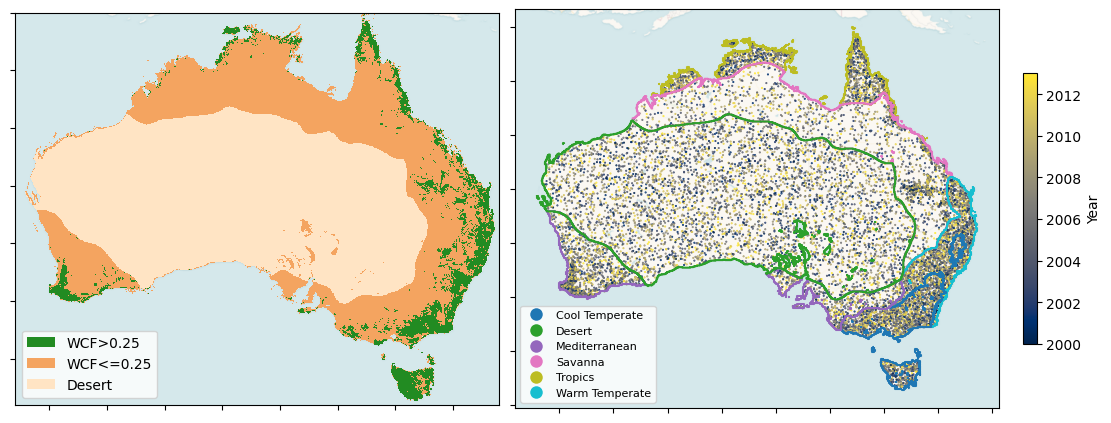

In [22]:
fig,ax=plt.subplots(1,2, figsize=(11,5), layout='constrained')

# xr.where(trees>0.25, 1, np.nan).plot(ax=ax[0], cmap='plasma_r', add_labels=False, add_colorbar=False)

cmap = ['forestgreen','sandybrown','bisque']
combined.plot(cmap=ListedColormap(cmap), ax=ax[0],add_colorbar=False, add_labels=False)
ax[0].legend(
        [Patch(facecolor=cmap[0]), Patch(facecolor=cmap[1]), Patch(facecolor=cmap[2])], 
        ['WCF>0.25', 'WCF<=0.25' ,'Desert'],
         loc = 'lower left'
    );

ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
# ax[0].set_title('Woody Cover Fraction > 0.25')

bio.plot(column='region_name', cmap='tab10', ax=ax[1], alpha=1, legend=True,
         legend_kwds={'loc': 'lower left','markerscale':0.9, 'fontsize':8})
gdf.plot(column='year', markersize=0.25, cmap='cividis', ax=ax[1], legend=True, legend_kwds={'shrink':0.55, 'label':'Year'})

ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
# ax[1].set_title('Distribution of validation samples and bioclimatic regions');
ax[1].set_yticklabels([])
ax[1].set_xticklabels([]);

fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/wcf_and_validation_samples_figure.png', bbox_inches='tight', dpi=300)